In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from config import db_password
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
# set up the connection to our Postgres db 
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' 
POSTGRES_PASSWORD = db_password
POSTGRES_DBNAME = 'db_segment2'

In [3]:
## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))

In [4]:
# Create the connection
cnx = create_engine(postgres_str)


In [5]:
# read the file
merge = pd.read_sql_query('''SELECT * FROM merge;''', cnx)

In [6]:
merge_df = pd.DataFrame(merge)
merge_df

,DBN,ell_num,sped_num,asian_num,black_num,hispanic_num,white_num,male_num,female_num,Total Cohort #,...,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# English Language Learners,# Poverty,Economic Need Index
0,01M292,52.0,124.0,56,158,272,12,281.0,234.0,5,...,125,27,58,127,0,4,6,21,191.00,87.8
1,01M448,54.0,111.0,110,128,232,18,275.0,213.0,59,...,267,141,100,206,1,2,15,49,415.00,82.9
2,01M450,27.0,146.0,34,145,326,33,285.0,261.0,76,...,366,81,113,367,6,6,100,6,447.00,62.9
3,01M458,4.0,19.0,3,59,136,8,96.0,117.0,70,...,86,1,70,121,1,1,9,16,176.00,85.0
4,01M515,462.0,4.0,501,24,24,2,314.0,237.0,234,...,320,318,58,165,0,6,10,392,431.00,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,32K549,52.0,53.0,3,97,237,1,167.0,180.0,57,...,194,4,69,275,1,2,11,118,310.00,92.1
406,32K552,69.0,47.0,5,112,239,3,193.0,170.0,85,...,112,2,35,154,0,0,4,51,187.15,91.2
407,32K554,10.0,15.0,6,53,174,1,120.0,117.0,5,...,194,31,36,332,0,0,35,7,373.00,70.8
408,32K556,58.0,35.0,5,54,231,1,122.0,178.0,77,...,155,2,48,222,0,0,3,75,266.95,92.7


In [7]:
# counts the number of not empty values for each row
merge_df.count()

DBN                            410
ell_num                        400
sped_num                       398
asian_num                      410
black_num                      410
hispanic_num                   410
white_num                      410
male_num                       404
female_num                     409
Total Cohort #                 410
Total Grads #                  410
Total Regents #                410
Advanced Regents #             410
Regents w/o Advanced #         410
Local #                        410
Still Enrolled #               410
Dropped Out #                  410
School Name                    410
Year                           410
Total Enrollment               410
# Female                       410
# Male                         410
# Asian                        410
# Black                        410
# Hispanic                     410
# Multi-Racial                 410
# Native American              410
# White                        410
# English Language L

In [8]:
# fill null values with zero
merge_df = merge_df.fillna(0)

In [9]:
# counts the number of not empty values for each row
merge_df.count()

DBN                            410
ell_num                        410
sped_num                       410
asian_num                      410
black_num                      410
hispanic_num                   410
white_num                      410
male_num                       410
female_num                     410
Total Cohort #                 410
Total Grads #                  410
Total Regents #                410
Advanced Regents #             410
Regents w/o Advanced #         410
Local #                        410
Still Enrolled #               410
Dropped Out #                  410
School Name                    410
Year                           410
Total Enrollment               410
# Female                       410
# Male                         410
# Asian                        410
# Black                        410
# Hispanic                     410
# Multi-Racial                 410
# Native American              410
# White                        410
# English Language L

In [10]:
#Statistical Details of the dataset
merge_df.describe()

,ell_num,sped_num,asian_num,black_num,hispanic_num,white_num,male_num,female_num,Total Cohort #,Total Grads #,...,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# English Language Learners,# Poverty,Economic Need Index
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,...,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,73.819512,74.997561,110.051220,210.080488,258.573171,102.375610,347.339024,347.207317,97.502439,70.463415,...,355.360976,125.875610,177.643902,275.914634,4.063415,6.802439,102.631707,83.951220,523.686707,77.078537
std,147.477077,102.841928,312.717664,276.294828,356.055723,294.730311,493.595733,462.590868,144.222242,111.591575,...,417.913090,339.852782,178.264522,257.617379,12.390385,13.142160,273.181864,128.573583,540.472580,15.901799
min,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,53.000000,23.200000
25%,6.000000,14.000000,4.000000,59.250000,56.500000,3.000000,91.250000,98.500000,25.000000,12.000000,...,164.000000,7.000000,75.000000,109.250000,0.000000,2.000000,7.000000,15.000000,268.750000,70.800000
50%,20.000000,41.000000,11.000000,125.000000,159.000000,8.500000,182.500000,203.000000,64.500000,42.000000,...,226.500000,18.500000,125.000000,212.000000,1.000000,3.000000,13.500000,34.500000,365.500000,80.850000
75%,61.000000,84.750000,55.500000,236.500000,292.500000,41.500000,308.500000,321.500000,96.000000,71.000000,...,338.500000,80.750000,214.500000,331.750000,3.000000,7.000000,61.750000,84.750000,487.837500,88.975000
max,1095.000000,733.000000,3104.000000,1934.000000,2903.000000,3123.000000,3002.000000,2442.000000,986.000000,825.000000,...,3531.000000,3545.000000,1107.000000,1602.000000,151.000000,130.000000,3020.000000,1021.000000,3527.000000,95.000000


# PreProcessing the Data
## Define X and Y
This is like extracting dependent and independent variables.

We have to define x and y for the model. x and y are input and output features of the dataset. So taking x features as input values that are independent, our model will predict the outcome which is y that are dependent.


## 1.First, we define the features set.

In [11]:
# Define the features set.
X = merge_df.copy()
X = X.drop(columns=["DBN","asian_num","black_num","hispanic_num","white_num","School Name","Year","Dropped Out #"])
            
X.head()

,ell_num,sped_num,male_num,female_num,Total Cohort #,Total Grads #,Total Regents #,Advanced Regents #,Regents w/o Advanced #,Local #,...,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# English Language Learners,# Poverty,Economic Need Index
0,52.0,124.0,281.0,234.0,5,4.0,0.0,0.0,0.0,4.0,...,125,27,58,127,0,4,6,21,191.0,87.8
1,54.0,111.0,275.0,213.0,59,31.0,19.0,3.0,16.0,12.0,...,267,141,100,206,1,2,15,49,415.0,82.9
2,27.0,146.0,285.0,261.0,76,65.0,64.0,0.0,64.0,1.0,...,366,81,113,367,6,6,100,6,447.0,62.9
3,4.0,19.0,96.0,117.0,70,12.0,9.0,0.0,9.0,3.0,...,86,1,70,121,1,1,9,16,176.0,85.0
4,462.0,4.0,314.0,237.0,234,59.0,59.0,37.0,22.0,0.0,...,320,318,58,165,0,6,10,392,431.0,95.0


## 2.Next, we define the target set. Here, we're using the ravel() method, which performs the same procedure on our target set data as the values attribute.



In [12]:
# Define the target set.
y = merge_df["Dropped Out #"].ravel()
y[:5]

array([  1.,   6.,   2.,  40., 104.])

## 3. Now, we split into the training and testing sets.
##   Now, split our dataset into two parts in which 80% of the dataset will go to the training set, and 20% of the dataset will go to the testing set. 


In [13]:
# # Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2,random_state=78)

In [14]:
# Print the shape of X_train, X_test, y_train, and y_test. Add the following code to do this:

print("X_train : ",X_train.shape)

print("X_test : ",X_test.shape)

print("y_train : ",y_train.shape)

print("y_test : ",y_test.shape)



X_train :  (328, 23)
X_test :  (82, 23)
y_train :  (328,)
y_test :  (82,)


#   feature engineering and the feature selection
## Fit the Model, Make Predictions, and Evaluate Results

## Regression models

In [15]:
#  Create a random forest regressor.
rf_model = RandomForestRegressor(n_estimators=200, random_state=78) 

In [16]:
# # Fitting the model
rf_model = rf_model.fit(X_train, y_train)
rf_model

RandomForestRegressor(n_estimators=200, random_state=78)

In [17]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test)

In [18]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2_score(y_test,predictions)

0.6075674602498352

## DecisionTreeRegressor

In [19]:
# Training the Decision Tree Regression model on the Training set
from sklearn.tree import DecisionTreeRegressor
rf_model = DecisionTreeRegressor(random_state = 0)
rf_model = rf_model.fit(X_train, y_train)
rf_model

DecisionTreeRegressor(random_state=0)

In [20]:
# Predicting the Test set results
predictions = rf_model.predict(X_test)

In [21]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2 = r2_score(y_test,predictions)
print('r2 score for a worse model is', r2)

r2 score for a worse model is -0.27157994218157877


## Support Vector Regression

In [22]:
# Training the Support Vector Regression model on the Training set
from sklearn.svm import SVR
rf_model = SVR(kernel = 'rbf')
rf_model = rf_model.fit(X_train, y_train)
rf_model


SVR()

In [23]:
# Predicting the Test set results
predictions = rf_model.predict(X_test)

In [24]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2_score(y_test,predictions)


0.08506255826618381

##  multiple linear regression 

## To train the model, we have to import the Linear Regression model. Use the fit method, and pass the training sets into it to train the model.



In [25]:
# Training the multiple regression model on the Training set
from sklearn.linear_model import LinearRegression
rf_model = LinearRegression()
rf_model = rf_model.fit(X_train, y_train)
rf_model

LinearRegression()

## Predict the Test Results
Use the predict method to predict the results, then pass the independent variables into it and view the results. It will give the array with all the values in it.



In [26]:
# Predicting the Test set results
predictions = rf_model.predict(X_test)
predictions

array([ 1.83926200e-01,  7.68135315e+00,  5.10463361e+00,  3.62234243e+00,
        7.82483547e+00, -1.07073893e+00,  5.88761834e+01,  1.80159395e+00,
        7.11757617e+00,  1.30949030e+01,  1.68783663e+01,  1.02681466e+01,
        1.84978724e+01, -2.49966989e+00, -9.34626768e-01, -7.16495156e-01,
        1.26926186e+01,  1.36255058e+01, -7.26905614e-01, -3.16627671e+00,
        3.04866594e+00, -2.38970814e-01, -1.67403871e+00,  1.96318410e+00,
        6.99897397e+00,  2.29542186e+02,  2.64206889e+00,  3.47485458e+00,
        2.44046153e+00,  1.50470489e+00,  5.01250711e-01,  4.67952502e+00,
        1.03498038e+01, -4.38444255e-01,  3.28798918e+00,  1.58361895e+00,
        3.31900412e-01,  8.71141827e+00,  2.50956767e+00,  2.31223634e+00,
       -1.63971337e-01,  9.45616352e+00,  8.60084550e+00,  2.71063706e+01,
        3.40480874e+00,  7.85567075e+00,  2.02951185e-01,  1.34505004e+01,
        2.10715976e+00,  4.66238056e+00,  8.91758072e+00, -1.44652249e+00,
        8.32088035e+00,  

## Evaluate the Model
We have different metrics to find the accuracy score of the model, and here we use r2_score to evaluate our model and find its accuracy.



In [27]:
# Evaluate the performance.
from sklearn.metrics import r2_score
r2_score(y_test,predictions)


0.9844782486300152

## Predicted Values
Let us create a new data frame that contains actual values, predicted values, and differences between them so that we will understand how near the model predicts its actual value.

In [28]:
pred_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':predictions,'Difference':y_test-predictions})

## View the dataframe

In [29]:
pred_df

,Actual Value,Predicted Value,Difference
0,0.0,0.183926,-0.183926
1,9.0,7.681353,1.318647
2,4.0,5.104634,-1.104634
3,4.0,3.622342,0.377658
4,6.0,7.824835,-1.824835
...,...,...,...
77,2.0,1.210497,0.789503
78,4.0,4.197307,-0.197307
79,10.0,8.902057,1.097943
80,1.0,0.854469,0.145531


## Here we can see the difference between Actual values and predicted values which are not very high.

## Plot the Results
We will plot the scatter plot between actual values and predicted values. Use xlabel to label the x-axis and use ylabel to label the y-axis.

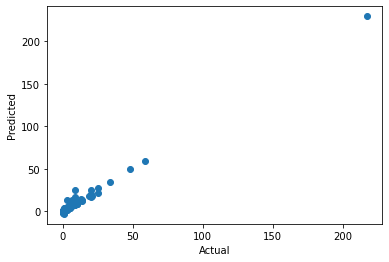

In [31]:
plt.scatter(y_test,predictions);
plt.xlabel('Actual');
plt.ylabel('Predicted');

## Regression plot of our model.

A regression plot is useful to understand the linear relationship between two parameters. It creates a regression line in-between those parameters and then plots a scatter plot of those data points.



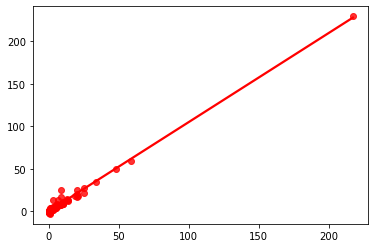

In [33]:
sns.regplot(x=y_test,y=predictions,ci=None,color ='red');

In [34]:
print("Multiple linear regression: 98%")
print("Support Vector Regression: 5%")
print("Decision Tree Regression: 35%")
print("Random Forest Regression: 61%")

Multiple linear regression: 98%
Support Vector Regression: 5%
Decision Tree Regression: 35%
Random Forest Regression: 61%


## Multiple linear regression performed the best out of all the four regression models. So we decided to go with this model to predict output values. We didn't see any limitations as the accuracy score is near 100%.
## Benefit: This approach has led to a more accurate and precise understanding of the association of each factor with the outcome.
